# Image classification on celeb A dataset

In [1]:
!pip install --user pyxlsb


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [6]:
import tensorflow as tf
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import os
import subprocess
import zipfile
import pandas as pd
import numpy as np
import os
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import time
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import warnings
import absl.logging
warnings.filterwarnings('ignore', message='You are saving your model as an HDF5 file')
absl.logging.set_verbosity(absl.logging.ERROR)
from tensorflow.keras.applications import VGG16

In [21]:
# Load celebrity metadata
celeb_data = pd.read_excel("list_attr_celeba_with_identity.xlsb", engine='pyxlsb')
celeb_data = celeb_data.dropna(subset=['image_id', 'Celeb_identity'])
celeb_data['Celeb_identity'] = celeb_data['Celeb_identity'].astype(int)

In [22]:
print(f"Dataset: {len(celeb_data)} samples, {celeb_data['Celeb_identity'].nunique()} identities")

Dataset: 202599 samples, 10177 identities


In [23]:
base_dir = './celeba_dataset'
img_dir = None
for path in [f"{base_dir}/img_align_celeba/img_align_celeba", 
             f"{base_dir}/img_align_celeba", base_dir]:
    if Path(path).exists():
        img_dir = path
        break

In [24]:
# Prepare paths and encode labels
img_paths = [str(Path(img_dir) / img) for img in celeb_data['image_id']]
encoder = LabelEncoder()
labels = encoder.fit_transform(celeb_data['Celeb_identity'])
n_classes = len(encoder.classes_)


In [25]:
# Image preprocessing function
@tf.function
def preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128, 128])
    img = tf.cast(img, tf.float32) / 255.0
    # Add augmentation for training
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.1)
    return img, label

In [26]:
# Create datasets
dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels))
dataset = dataset.shuffle(10000, seed=42)

In [27]:
split = int(0.8 * len(img_paths))
train_ds = dataset.take(split).map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = dataset.skip(split).map(lambda x,y: (preprocess(x,y)[0], y)).batch(32).prefetch(tf.data.AUTOTUNE)

In [28]:
print(f"Train: {split} samples, Val: {len(img_paths)-split} samples")

Train: 162079 samples, Val: 40520 samples


# Build custom CNN model


In [29]:
# Build CNN model
def create_model(n_classes):
    return tf.keras.Sequential([
        # Block 1
        tf.keras.layers.Conv2D(48, 3, padding='same', activation='relu', input_shape=(128,128,3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        
        # Block 2  
        tf.keras.layers.Conv2D(96, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        
        # Block 3
        tf.keras.layers.Conv2D(192, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        
        # Block 4
        tf.keras.layers.Conv2D(384, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAvgPool2D(),
        
        # Dense layers
        tf.keras.layers.Dense(640, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(320, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_classes, activation='softmax')
    ])

In [30]:
# Create and compile model
model = create_model(n_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Model params: {model.count_params():,}")

Model params: 4,594,145


/opt/miniconda/envs/eai/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
# Training callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', 
        patience=5, 
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

# Trying to train the model with complete dataset

In [32]:
# Train model
history = model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds,
    callbacks=callbacks
)

print(f"Best val accuracy: {max(history.history['val_accuracy']):.4f}")

Epoch 1/5


2025-09-29 21:31:17.277203: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.13 = (f32[32,96,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,48,64,64]{3,2,1,0} %bitcast.10935, f32[96,48,3,3]{3,2,1,0} %bitcast.9628, f32[96]{0} %bitcast.10995), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_2_1/conv2d_19_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-29 21:31:17.448492: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted 

5064/5065 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 2.1190e-04 - loss: 9.1141

2025-09-29 21:38:16.468804: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.13 = (f32[31,96,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,48,64,64]{3,2,1,0} %bitcast.10935, f32[96,48,3,3]{3,2,1,0} %bitcast.9628, f32[96]{0} %bitcast.10995), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_2_1/conv2d_19_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-29 21:38:16.618061: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted 

5065/5065 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 2.1187e-04 - loss: 9.1141

2025-09-29 21:38:22.077400: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.13 = (f32[32,96,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,48,64,64]{3,2,1,0} %bitcast.795, f32[96,48,3,3]{3,2,1,0} %bitcast.802, f32[96]{0} %bitcast.804), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_2_1/conv2d_19_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-29 21:38:22.250564: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted poten

5065/5065 ━━━━━━━━━━━━━━━━━━━━ 523s 102ms/step - accuracy: 2.1185e-04 - loss: 9.1141 - val_accuracy: 0.0000e+00 - val_loss: 11.5114 - learning_rate: 0.0010
Epoch 2/5
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 199s 39ms/step - accuracy: 1.2842e-04 - loss: 8.9230 - val_accuracy: 0.0000e+00 - val_loss: 12.2594 - learning_rate: 0.0010
Epoch 3/5
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 200s 40ms/step - accuracy: 3.0049e-04 - loss: 8.9075 - val_accuracy: 4.9358e-05 - val_loss: 13.5348 - learning_rate: 0.0010
Epoch 4/5
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 189s 37ms/step - accuracy: 2.0236e-04 - loss: 8.9018 - val_accuracy: 2.4679e-05 - val_loss: 14.2243 - learning_rate: 0.0010
Epoch 5/5
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 202s 40ms/step - accuracy: 2.3362e-04 - loss: 8.8978 - val_accuracy: 2.4679e-05 - val_loss: 14.4563 - learning_rate: 5.0000e-04
Best val accuracy: 0.0000


In [33]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_transfer_model(n_classes):
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        input_shape=(128,128,3),
        weights="imagenet"
    )
    base_model.trainable = False  # freeze backbone first

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(n_classes, activation='softmax')
    ])
    return model

# Compile & train
transfer_model = create_transfer_model(n_classes)
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Transfer model params: {transfer_model.count_params():,}")

history = transfer_model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds,
    callbacks=callbacks
)

# Fine-tune: unfreeze top EfficientNet layers
transfer_model.layers[0].trainable = True
for layer in transfer_model.layers[0].layers[:-50]:
    layer.trainable = False

transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_ft = transfer_model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds,
    callbacks=callbacks
)


Transfer model params: 9,931,364
Epoch 1/5
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 234s 42ms/step - accuracy: 1.1178e-04 - loss: 9.1293 - val_accuracy: 0.0000e+00 - val_loss: 11.3503 - learning_rate: 0.0010
Epoch 2/5
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 194s 38ms/step - accuracy: 6.1839e-05 - loss: 8.9226 - val_accuracy: 2.4679e-05 - val_loss: 12.6015 - learning_rate: 0.0010
Epoch 3/5
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 197s 39ms/step - accuracy: 2.7222e-04 - loss: 8.9056 - val_accuracy: 0.0000e+00 - val_loss: 13.5574 - learning_rate: 0.0010
Epoch 4/5
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 203s 40ms/step - accuracy: 2.4865e-04 - loss: 8.9010 - val_accuracy: 0.0000e+00 - val_loss: 14.2400 - learning_rate: 0.0010
Epoch 5/5
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 200s 39ms/step - accuracy: 1.8071e-04 - loss: 8.8972 - val_accuracy: 0.0000e+00 - val_loss: 14.4698 - learning_rate: 5.0000e-04
Epoch 1/5


2025-09-29 22:16:16.335812: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-29 22:16:16.531384: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-29 22:16:16.816701: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-29 22:16:17.030575: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-29 22:16:17.342423: E external/local_xla/xla/stream_

5064/5065 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.4146e-04 - loss: 8.9085

2025-09-29 22:19:08.732724: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-29 22:19:08.928458: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-29 22:19:09.222188: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-29 22:19:09.440322: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-29 22:19:09.749174: E external/local_xla/xla/stream_

5065/5065 ━━━━━━━━━━━━━━━━━━━━ 253s 45ms/step - accuracy: 1.4148e-04 - loss: 8.9086 - val_accuracy: 4.9358e-05 - val_loss: 11.9945 - learning_rate: 1.0000e-04
Epoch 2/5
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 203s 40ms/step - accuracy: 2.2919e-04 - loss: 8.9026 - val_accuracy: 2.4679e-05 - val_loss: 11.7228 - learning_rate: 1.0000e-04
Epoch 3/5
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 203s 40ms/step - accuracy: 2.0936e-04 - loss: 8.9009 - val_accuracy: 0.0000e+00 - val_loss: 11.2652 - learning_rate: 1.0000e-04
Epoch 4/5
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 208s 41ms/step - accuracy: 1.5088e-04 - loss: 8.9023 - val_accuracy: 4.9358e-05 - val_loss: 11.4206 - learning_rate: 1.0000e-04
Epoch 5/5
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 206s 41ms/step - accuracy: 1.8306e-04 - loss: 8.9017 - val_accuracy: 4.9358e-05 - val_loss: 11.3002 - learning_rate: 1.0000e-04


The main problem with the CelebA dataset is that it has over 10,000 different celebrities, but the photos are distributed very unfairly - some celebrities have more than 30 photos while most have only 1 or 2 photos. This makes it extremely hard for the model to learn because to recognize someone's face properly, you need many different photos of them showing different angles, lighting, and expressions. When you only have 2 photos of someone, the model can't really learn what makes their face unique, it just memorizes those exact 2 photos. The model ends up being good at recognizing celebrities it has seen many times but completely fails on the thousands of celebrities with very few photos.

## Training for top celebrities with decent amount of images

In [7]:
print("STEP 1: LOADING AND FILTERING CELEBRITY DATA")
print("=" * 50)
identity_file = "./identity_CelebA.xlsx"
df_identity = pd.read_excel(identity_file)

print(f"Original dataset shape: {df_identity.shape}")
print(f"Total images: {len(df_identity)}")
print(f"Total unique celebrities: {df_identity.iloc[:, 1].nunique()}")
celebrity_counts = df_identity.iloc[:, 1].value_counts()

print(f"\nCelebrity distribution:")
print(f"Min images per celebrity: {celebrity_counts.min()}")
print(f"Max images per celebrity: {celebrity_counts.max()}")
print(f"Mean images per celebrity: {celebrity_counts.mean():.1f}")

celebrities_with_2plus = celebrity_counts[celebrity_counts >= 2]
print(f"\nCelebrities with 2+ images: {len(celebrities_with_2plus)}")

valid_celebrities = celebrities_with_2plus.index.tolist()
df_filtered = df_identity[df_identity.iloc[:, 1].isin(valid_celebrities)].copy()

print(f"Filtered dataset:")
print(f"Images: {len(df_filtered)}")
print(f"Celebrities (classes): {len(valid_celebrities)}")

celebrity_to_label = {celeb_id: idx for idx, celeb_id in enumerate(valid_celebrities)}
df_filtered['celebrity_label'] = df_filtered.iloc[:, 1].map(celebrity_to_label)
df_filtered.columns = ['image_filename', 'celebrity_id', 'celebrity_label']

print(f"\nSample data:")
print(df_filtered.head())

print(f"\nClass distribution (first 10 classes):")
class_counts = df_filtered['celebrity_label'].value_counts().sort_index()
for i in range(min(10, len(class_counts))):
    celeb_id = valid_celebrities[i]
    count = class_counts[i]
    print(f"Class {i} (Celebrity {celeb_id}): {count} images")

print(f"\n Step 1 Complete!")
print(f"Ready for training with {len(valid_celebrities)} celebrity classes")

STEP 1: LOADING AND FILTERING CELEBRITY DATA
Original dataset shape: (202599, 2)
Total images: 202599
Total unique celebrities: 10177

Celebrity distribution:
Min images per celebrity: 1
Max images per celebrity: 35
Mean images per celebrity: 19.9

Celebrities with 2+ images: 10133
Filtered dataset:
Images: 202555
Celebrities (classes): 10133

Sample data:
  image_filename  celebrity_id  celebrity_label
0     000001.jpg          2880               32
1     000002.jpg          2937             1171
2     000003.jpg          8692             2096
3     000004.jpg          5805             2102
4     000005.jpg          9295             3541

Class distribution (first 10 classes):
Class 0 (Celebrity 3227): 35 images
Class 1 (Celebrity 2820): 35 images
Class 2 (Celebrity 3782): 35 images
Class 3 (Celebrity 3745): 34 images
Class 4 (Celebrity 3699): 34 images
Class 5 (Celebrity 9152): 32 images
Class 6 (Celebrity 8968): 32 images
Class 7 (Celebrity 9256): 32 images
Class 8 (Celebrity 4887):

# CREATING MANAGEABLE SUBSET FOR TRAINING

In [9]:
print("STEP 2: CREATING MANAGEABLE SUBSET FOR TRAINING")
print("=" * 50)

N_CELEBRITIES = 100

print(f"Selecting top {N_CELEBRITIES} celebrities with most images...")
celebrity_counts = df_filtered['celebrity_id'].value_counts()
top_celebrities = celebrity_counts.head(N_CELEBRITIES).index.tolist()

print(f"Top {N_CELEBRITIES} celebrities image counts:")
print(f"Max: {celebrity_counts.iloc[0]} images")
print(f"Min: {celebrity_counts.iloc[N_CELEBRITIES-1]} images") 

df_subset = df_filtered[df_filtered['celebrity_id'].isin(top_celebrities)].copy()

top_celebrity_to_label = {celeb_id: idx for idx, celeb_id in enumerate(top_celebrities)}
df_subset['celebrity_label'] = df_subset['celebrity_id'].map(top_celebrity_to_label)

print(f"\nSubset dataset:")
print(f"Images: {len(df_subset)}")
print(f"Classes: {len(top_celebrities)}")
print(f"Average images per class: {len(df_subset)/len(top_celebrities):.1f}")
class_dist = df_subset['celebrity_label'].value_counts()
print(f"\nClass distribution stats:")
print(f"Min images per class: {class_dist.min()}")
print(f"Max images per class: {class_dist.max()}")

df_subset.to_csv('./celebrity_subset.csv', index=False)
print(f"\n Saved subset to: celebrity_subset.csv")

print(f"\nSample of subset data:")
print(df_subset.head(10))

print(f"\n Step 2 Complete!")
print(f"Ready to proceed with {len(top_celebrities)} classes and {len(df_subset)} images")

NUM_CLASSES = len(top_celebrities)
TOTAL_IMAGES = len(df_subset)

print(f"\nFor next steps:")
print(f"NUM_CLASSES = {NUM_CLASSES}")
print(f"TOTAL_IMAGES = {TOTAL_IMAGES}")

STEP 2: CREATING MANAGEABLE SUBSET FOR TRAINING
Selecting top 100 celebrities with most images...
Top 100 celebrities image counts:
Max: 35 images
Min: 30 images

Subset dataset:
Images: 3038
Classes: 100
Average images per class: 30.4

Class distribution stats:
Min images per class: 30
Max images per class: 35

 Saved subset to: celebrity_subset.csv

Sample of subset data:
     image_filename  celebrity_id  celebrity_label
0        000001.jpg          2880               23
95       000096.jpg          4262               13
115      000116.jpg          4887               15
149      000150.jpg          6568               11
403      000404.jpg          2880               23
837      000838.jpg          4887               15
1552     001553.jpg          2820                0
1785     001786.jpg          1757               14
2278     002279.jpg          3745                4
2557     002558.jpg          2820                0

 Step 2 Complete!
Ready to proceed with 100 classes and 3038 

STEP 3: LOADING AND PREPROCESSING IMAGES
Loading 3038 images...
Target image size: (64, 64)
Image directory: ./celeba_dataset/img_align_celeba/img_align_celeba
Processed 0/3038 images...
Processed 500/3038 images...
Processed 1000/3038 images...
Processed 1500/3038 images...
Processed 2000/3038 images...
Processed 2500/3038 images...
Processed 3000/3038 images...

Image loading complete!
Successfully loaded: 3038 images
Failed loads: 0
Image array shape: (3038, 64, 64, 3)
Labels array shape: (3038,)
Image data type: float64
Pixel value range: 0.000 to 1.000

Displaying sample images from different celebrities...


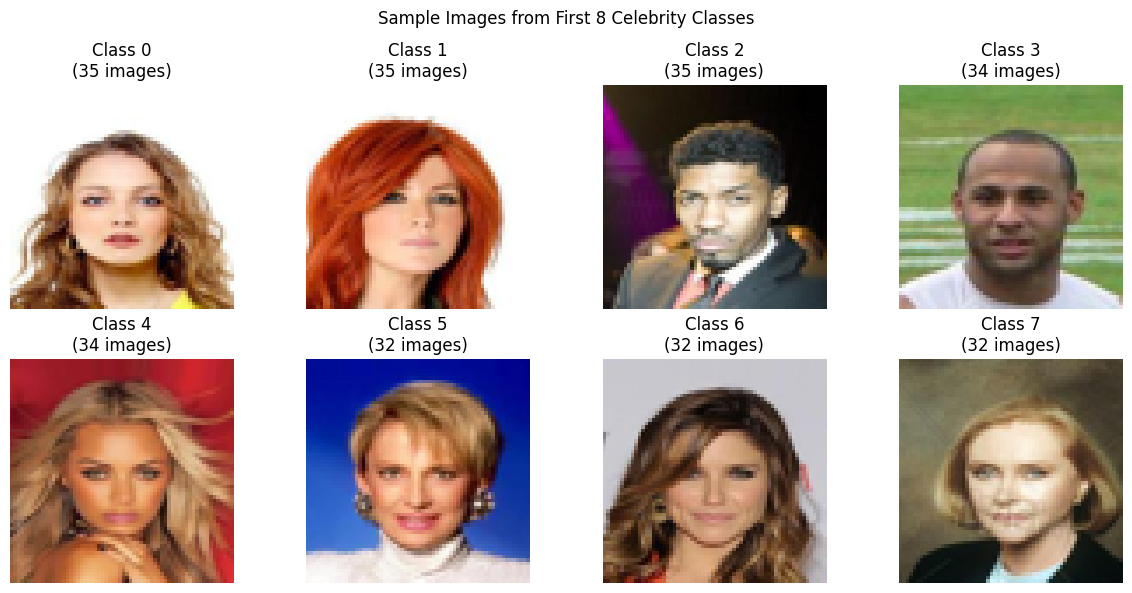


Class distribution in loaded data:
Number of classes: 100
Min images per class: 30
Max images per class: 35
Mean images per class: 30.4

 Step 3 Complete!
Ready for train/validation/test split!

For next steps:
X.shape = (3038, 64, 64, 3)
y.shape = (3038,)
NUM_CLASSES = 100


In [10]:
print("STEP 3: LOADING AND PREPROCESSING IMAGES")
print("=" * 50)
df_subset = pd.read_csv('./celebrity_subset.csv')
IMG_SIZE = (64, 64) 
IMG_DIR = "./celeba_dataset/img_align_celeba/img_align_celeba"

print(f"Loading {len(df_subset)} images...")
print(f"Target image size: {IMG_SIZE}")
print(f"Image directory: {IMG_DIR}")
images = []
labels = []
failed_loads = 0
for idx, row in df_subset.iterrows():
    if idx % 500 == 0:
        print(f"Processed {idx}/{len(df_subset)} images...")
    
    img_path = os.path.join(IMG_DIR, row['image_filename'])
    
    if os.path.exists(img_path):
        try:
            # Load image
            img = Image.open(img_path).convert('RGB')
            
            # Resize image
            img = img.resize(IMG_SIZE)
            
            # Convert to numpy array and normalize (0-1)
            img_array = np.array(img) / 255.0
            
            images.append(img_array)
            labels.append(row['celebrity_label'])
            
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            failed_loads += 1
    else:
        print(f"File not found: {img_path}")
        failed_loads += 1

X = np.array(images)
y = np.array(labels)

print(f"\nImage loading complete!")
print(f"Successfully loaded: {len(X)} images")
print(f"Failed loads: {failed_loads}")
print(f"Image array shape: {X.shape}")
print(f"Labels array shape: {y.shape}")
print(f"Image data type: {X.dtype}")
print(f"Pixel value range: {X.min():.3f} to {X.max():.3f}")

print(f"\nDisplaying sample images from different celebrities...")

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

sample_classes = np.unique(y)[:8]  # First 8 classes
for i, class_id in enumerate(sample_classes):
    # Find first image of this class
    class_indices = np.where(y == class_id)[0]
    if len(class_indices) > 0:
        img_idx = class_indices[0]
        
        axes[i].imshow(X[img_idx])
        axes[i].set_title(f'Class {class_id}\n({len(class_indices)} images)')
        axes[i].axis('off')

plt.suptitle('Sample Images from First 8 Celebrity Classes')
plt.tight_layout()
plt.show()
unique_labels, counts = np.unique(y, return_counts=True)
print(f"\nClass distribution in loaded data:")
print(f"Number of classes: {len(unique_labels)}")
print(f"Min images per class: {counts.min()}")
print(f"Max images per class: {counts.max()}")
print(f"Mean images per class: {counts.mean():.1f}")

print(f"\n Step 3 Complete!")
print(f"Ready for train/validation/test split!")
print(f"\nFor next steps:")
print(f"X.shape = {X.shape}")
print(f"y.shape = {y.shape}")
print(f"NUM_CLASSES = {len(unique_labels)}")

# Splitting the data

In [12]:
print("STEP 4: TRAIN/VALIDATION/TEST SPLIT")
print("=" * 50)
np.random.seed(42)
tf.random.set_seed(42)

print(f"Original dataset: {X.shape[0]} images, {len(np.unique(y))} classes")
X_shuffled, y_shuffled = shuffle(X, y, random_state=42)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_shuffled, y_shuffled, 
    test_size=0.15, 
    random_state=42, 
    stratify=y_shuffled  
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.176, 
    random_state=42, 
    stratify=y_temp
)

print(f"\nData split:")
print(f"Training set:   {X_train.shape[0]} images ({X_train.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} images ({X_val.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]} images ({X_test.shape[0]/X.shape[0]*100:.1f}%)")


train_classes = len(np.unique(y_train))
val_classes = len(np.unique(y_val))
test_classes = len(np.unique(y_test))

print(f"\nClasses in each split:")
print(f"Training:   {train_classes} classes")
print(f"Validation: {val_classes} classes") 
print(f"Test:       {test_classes} classes")


def check_class_distribution(y_split, split_name):
    unique, counts = np.unique(y_split, return_counts=True)
    print(f"\n{split_name} class distribution:")
    print(f"  Min images per class: {counts.min()}")
    print(f"  Max images per class: {counts.max()}")
    print(f"  Mean images per class: {counts.mean():.1f}")

check_class_distribution(y_train, "Training")
check_class_distribution(y_val, "Validation") 
check_class_distribution(y_test, "Test")
from tensorflow.keras.utils import to_categorical

y_train_categorical = to_categorical(y_train, num_classes=len(np.unique(y)))
y_val_categorical = to_categorical(y_val, num_classes=len(np.unique(y)))
y_test_categorical = to_categorical(y_test, num_classes=len(np.unique(y)))

print(f"\nCategorical labels shape:")
print(f"y_train_categorical: {y_train_categorical.shape}")
print(f"y_val_categorical: {y_val_categorical.shape}")
print(f"y_test_categorical: {y_test_categorical.shape}")

# Verify data integrity
print(f"\nData integrity check:")
print(f"Training images shape: {X_train.shape}")
print(f"Training labels shape: {y_train_categorical.shape}")
print(f"Image pixel range: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f"All classes represented: {len(np.unique(y_train)) == len(np.unique(y))}")

print(f"Data is ready for CNN training!")

NUM_CLASSES = len(np.unique(y))
INPUT_SHAPE = X_train.shape[1:]  

print(f"\nFor model building:")
print(f"INPUT_SHAPE = {INPUT_SHAPE}")
print(f"NUM_CLASSES = {NUM_CLASSES}")
print(f"Training samples: {X_train.shape[0]}")

STEP 4: TRAIN/VALIDATION/TEST SPLIT
Original dataset: 3038 images, 100 classes

Data split:
Training set:   2127 images (70.0%)
Validation set: 455 images (15.0%)
Test set:       456 images (15.0%)

Classes in each split:
Training:   100 classes
Validation: 100 classes
Test:       100 classes

Training class distribution:
  Min images per class: 21
  Max images per class: 25
  Mean images per class: 21.3

Validation class distribution:
  Min images per class: 4
  Max images per class: 5
  Mean images per class: 4.5

Test class distribution:
  Min images per class: 4
  Max images per class: 5
  Mean images per class: 4.6

Categorical labels shape:
y_train_categorical: (2127, 100)
y_val_categorical: (455, 100)
y_test_categorical: (456, 100)

Data integrity check:
Training images shape: (2127, 64, 64, 3)
Training labels shape: (2127, 100)
Image pixel range: [0.000, 1.000]
All classes represented: True
Data is ready for CNN training!

For model building:
INPUT_SHAPE = (64, 64, 3)
NUM_CLASS

# Model Definition

In [15]:

print("DEFINING ALL MODELS")



MODEL_RESULTS = {}
TRAINED_MODELS = {}

def create_cnn_model():
    """Create a CNN model for celebrity classification"""
    
    model = models.Sequential([
       
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
     
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
       
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
      
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model


def create_vgg16_model():
    """VGG16 pre-trained model for celebrity classification"""
    from tensorflow.keras.applications import VGG16
    
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(128, 128, 3)
    )
    
    base_model.trainable = False
    
    model = models.Sequential([
        layers.Lambda(lambda x: tf.image.resize(x, [128, 128])),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

def create_deep_residual_cnn():
    """Deep CNN with residual connections"""
    
    inputs = layers.Input(shape=INPUT_SHAPE)
    
    
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
 
    shortcut = x
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)
    
    # Residual Block 2
    shortcut = layers.Conv2D(128, (1, 1), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    
  
    shortcut = layers.Conv2D(256, (1, 1), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(256, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)
    
    
    shortcut = layers.Conv2D(512, (1, 1), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(512, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    
 
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.6)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

print("All model definitions loaded")

DEFINING ALL MODELS
All model definitions loaded


In [16]:

print("\nSETTING UP TRAINING FUNCTION")


def train_and_evaluate_model(model_name, create_func, epochs=30, batch_size=32, learning_rate=0.001):
    """Train and evaluate a single model"""
    
    print(f"\n{'='*60}")
    print(f"TRAINING: {model_name}")
    print(f"{'='*60}")
    
   
    model = create_func()
 
    model.build(input_shape=(None,) + INPUT_SHAPE) 
    
   
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
  
    print(f"Model parameters: {model.count_params():,}")
    
    # Callbacks
    callbacks_list = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            f'{model_name}_best.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    
  
    print(f"Starting training...")
    start_time = time.time()
    
    history = model.fit(
        X_train, y_train_categorical,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val_categorical),
        callbacks=callbacks_list,
        verbose=1
    )
    
    training_time = time.time() - start_time
    
    
    test_loss, test_acc = model.evaluate(X_test, y_test_categorical, verbose=0)
    

    results = {
        'model_name': model_name,
        'model': model,
        'history': history,
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'best_val_accuracy': max(history.history['val_accuracy']),
        'final_train_accuracy': history.history['accuracy'][-1],
        'final_val_accuracy': history.history['val_accuracy'][-1],
        'training_time': training_time,
        'total_parameters': model.count_params()
    }
    
    MODEL_RESULTS[model_name] = results
    TRAINED_MODELS[model_name] = model
    
    print(f"\n{model_name} RESULTS:")
    print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.1f}%)")
    print(f"Best Val Accuracy: {results['best_val_accuracy']:.4f}")
    print(f"Training Time: {training_time/60:.1f} minutes")
    
    return results


SETTING UP TRAINING FUNCTION


# Model Training

In [17]:

print("\nSTARTING MODEL TRAINING")



MODELS_TO_TRAIN = [
    {
        'name': 'CNN_Model',
        'create_func': create_cnn_model,
        'epochs': 30,
        'batch_size': 32,
        'learning_rate': 0.001
    },
    {
        'name': 'VGG16_Transfer',
        'create_func': create_vgg16_model,
        'epochs': 50,
        'batch_size': 16,
        'learning_rate': 0.001
    },
    {
        'name': 'Deep_Residual_CNN',
        'create_func': create_deep_residual_cnn,
        'epochs': 60,
        'batch_size': 16,
        'learning_rate': 0.0005
    }
]


for model_config in MODELS_TO_TRAIN:
    train_and_evaluate_model(
        model_name=model_config['name'],
        create_func=model_config['create_func'],
        epochs=model_config['epochs'],
        batch_size=model_config['batch_size'],
        learning_rate=model_config['learning_rate']
    )

print("\n" + "="*60)
print("ALL MODELS TRAINED SUCCESSFULLY!")
print("="*60)


STARTING MODEL TRAINING

TRAINING: CNN_Model


/opt/miniconda/envs/eai/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1759195293.723948 4075576 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11437 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:04:00.0, compute capability: 6.0


Model parameters: 1,496,068
Starting training...
Epoch 1/30


I0000 00:00:1759195298.707486 4075980 service.cc:152] XLA service 0x1548b0001690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759195298.707515 4075980 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-12GB, Compute Capability 6.0
2025-09-29 21:21:38.834783: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759195299.485600 4075980 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-09-29 21:21:40.776910: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.18 = (f32[32,32,62,62]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,64,64]{3,2,1,0} %bitcast.17605, f32[32,3,3,3]{3,2,1,0} %bitcast.17612, f32[32]{0} %bitcast.18901), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAct

19/67 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0210 - loss: 5.9722

I0000 00:00:1759195306.299541 4075980 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/67 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0147 - loss: 5.8052

2025-09-29 21:21:48.053891: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.18 = (f32[15,32,62,62]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,3,64,64]{3,2,1,0} %bitcast.17605, f32[32,3,3,3]{3,2,1,0} %bitcast.17612, f32[32]{0} %bitcast.18901), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-29 21:21:48.061874: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy 

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.0147 - loss: 5.7852

2025-09-29 21:21:53.225313: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.18 = (f32[32,32,62,62]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,64,64]{3,2,1,0} %bitcast.810, f32[32,3,3,3]{3,2,1,0} %bitcast.817, f32[32]{0} %bitcast.819), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-29 21:21:53.240461: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algori


Epoch 1: val_accuracy improved from -inf to 0.01099, saving model to CNN_Model_best.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.0147 - loss: 5.7814 - val_accuracy: 0.0110 - val_loss: 4.7871 - learning_rate: 0.0010
Epoch 2/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0237 - loss: 4.9564
Epoch 2: val_accuracy did not improve from 0.01099
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0237 - loss: 4.9551 - val_accuracy: 0.0110 - val_loss: 5.0625 - learning_rate: 0.0010
Epoch 3/30
61/67 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0490 - loss: 4.6581
Epoch 3: val_accuracy improved from 0.01099 to 0.01758, saving model to CNN_Model_best.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0492 - loss: 4.6483 - val_accuracy: 0.0176 - val_loss: 5.1122 - learning_rate: 0.0010
Epoch 4/30
61/67 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0724 - loss: 4.3086
Epoch 4: val_accuracy did not improve from 0.01758
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step 

2025-09-29 21:22:17.945470: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.18 = (f32[8,32,62,62]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,3,64,64]{3,2,1,0} %bitcast.810, f32[32,3,3,3]{3,2,1,0} %bitcast.817, f32[32]{0} %bitcast.819), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-29 21:22:17.976337: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorith


CNN_Model RESULTS:
Test Accuracy: 0.5154 (51.5%)
Best Val Accuracy: 0.4945
Training Time: 0.7 minutes

TRAINING: VGG16_Transfer
Model parameters: 15,136,420
Starting training...
Epoch 1/50


2025-09-29 21:22:21.567423: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.39 = (f32[16,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,128,128]{3,2,1,0} %bitcast.6947, f32[64,3,3,3]{3,2,1,0} %bitcast.6954, f32[64]{0} %bitcast.6956), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/vgg16_1/block1_conv1_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-29 21:22:21.616477: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:54

131/133 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0183 - loss: 5.0251

2025-09-29 21:22:27.682265: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.39 = (f32[15,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,3,128,128]{3,2,1,0} %bitcast.6945, f32[64,3,3,3]{3,2,1,0} %bitcast.6952, f32[64]{0} %bitcast.6954), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/vgg16_1/block1_conv1_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-29 21:22:27.712282: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:54

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.0186 - loss: 5.0209

2025-09-29 21:22:32.356806: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.39 = (f32[7,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,3,128,128]{3,2,1,0} %bitcast.1144, f32[64,3,3,3]{3,2,1,0} %bitcast.1151, f32[64]{0} %bitcast.1153), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/vgg16_1/block1_conv1_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-29 21:22:32.419075: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549]


Epoch 1: val_accuracy improved from -inf to 0.05495, saving model to VGG16_Transfer_best.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - accuracy: 0.0187 - loss: 5.0188 - val_accuracy: 0.0549 - val_loss: 4.4246 - learning_rate: 0.0010
Epoch 2/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1101 - loss: 3.8633
Epoch 2: val_accuracy improved from 0.05495 to 0.15165, saving model to VGG16_Transfer_best.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.1102 - loss: 3.8629 - val_accuracy: 0.1516 - val_loss: 3.9529 - learning_rate: 0.0010
Epoch 3/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2247 - loss: 3.3116
Epoch 3: val_accuracy improved from 0.15165 to 0.17802, saving model to VGG16_Transfer_best.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.2246 - loss: 3.3112 - val_accuracy: 0.1780 - val_loss: 3.5433 - learning_rate: 0.0010
Epoch 4/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2775 - loss: 2.8999
Epoch 4: val_accurac

2025-09-29 21:23:18.553750: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.39 = (f32[32,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,128,128]{3,2,1,0} %bitcast.1144, f32[64,3,3,3]{3,2,1,0} %bitcast.1151, f32[64]{0} %bitcast.1153), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/vgg16_1/block1_conv1_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-29 21:23:18.662945: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:54


VGG16_Transfer RESULTS:
Test Accuracy: 0.2697 (27.0%)
Best Val Accuracy: 0.3297
Training Time: 1.0 minutes

TRAINING: Deep_Residual_CNN
Model parameters: 6,016,356
Starting training...
Epoch 1/60


2025-09-29 21:23:32.633159: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.51 = (f32[16,64,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,16,16]{3,2,1,0} %bitcast.26843, f32[64,64,3,3]{3,2,1,0} %bitcast.24511, f32[64]{0} %bitcast.26903), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_3_1/conv2d_7_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-29 21:23:32.705958: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted 

130/133 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0088 - loss: 6.5842

2025-09-29 21:23:43.412966: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.51 = (f32[15,64,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,64,16,16]{3,2,1,0} %bitcast.26843, f32[64,64,3,3]{3,2,1,0} %bitcast.24511, f32[64]{0} %bitcast.26903), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_3_1/conv2d_7_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-29 21:23:43.470100: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted 

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.0088 - loss: 6.5780

2025-09-29 21:23:51.277500: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.47 = (f32[16,64,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,16,16]{3,2,1,0} %bitcast.1345, f32[64,64,3,3]{3,2,1,0} %bitcast.1352, f32[64]{0} %bitcast.1354), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_3_1/conv2d_7_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-29 21:23:52.557848: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted pot


Epoch 1: val_accuracy improved from -inf to 0.01538, saving model to Deep_Residual_CNN_best.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - accuracy: 0.0088 - loss: 6.5759 - val_accuracy: 0.0154 - val_loss: 4.6698 - learning_rate: 5.0000e-04
Epoch 2/60
131/133 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0113 - loss: 5.8951
Epoch 2: val_accuracy did not improve from 0.01538
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0114 - loss: 5.8925 - val_accuracy: 0.0110 - val_loss: 4.8087 - learning_rate: 5.0000e-04
Epoch 3/60
131/133 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0120 - loss: 5.5411
Epoch 3: val_accuracy improved from 0.01538 to 0.02637, saving model to Deep_Residual_CNN_best.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.0120 - loss: 5.5395 - val_accuracy: 0.0264 - val_loss: 4.7985 - learning_rate: 5.0000e-04
Epoch 4/60
131/133 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0114 - loss: 5.3311
Epoch 4: val_accuracy improved from 0.02637 to 0

2025-09-29 21:25:17.163907: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.47 = (f32[32,64,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,16,16]{3,2,1,0} %bitcast.1345, f32[64,64,3,3]{3,2,1,0} %bitcast.1352, f32[64]{0} %bitcast.1354), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_3_1/conv2d_7_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-29 21:25:17.205602: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted pot


Deep_Residual_CNN RESULTS:
Test Accuracy: 0.3026 (30.3%)
Best Val Accuracy: 0.3187
Training Time: 1.9 minutes

ALL MODELS TRAINED SUCCESSFULLY!


# Comparing Models

In [18]:

# ============================================
# CELL 4: COMPARE MODELS AND FIND BEST
# ============================================
print("\nMODEL COMPARISON")
print("=" * 50)


comparison_data = []
for name, results in MODEL_RESULTS.items():
    comparison_data.append({
        'Model': name,
        'Test Accuracy': f"{results['test_accuracy']:.4f}",
        'Best Val Accuracy': f"{results['best_val_accuracy']:.4f}",
        'Parameters': f"{results['total_parameters']:,}",
        'Training Time (min)': f"{results['training_time']/60:.1f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))


best_model_name = max(MODEL_RESULTS.keys(), key=lambda x: MODEL_RESULTS[x]['test_accuracy'])
best_model = TRAINED_MODELS[best_model_name]
best_accuracy = MODEL_RESULTS[best_model_name]['test_accuracy']

print(f"\n BEST MODEL: {best_model_name}")
print(f"   Test Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.1f}%)")


best_model.save('best_celebrity_model_final.keras')
print(f"\n Best model saved as 'best_celebrity_model_final.keras'")



MODEL COMPARISON

Model Performance Comparison:
            Model Test Accuracy Best Val Accuracy Parameters Training Time (min)
        CNN_Model        0.5154            0.4945  1,496,068                 0.7
   VGG16_Transfer        0.2697            0.3297 15,136,420                 1.0
Deep_Residual_CNN        0.3026            0.3187  6,016,356                 1.9

 BEST MODEL: CNN_Model
   Test Accuracy: 0.5154 (51.5%)

 Best model saved as 'best_celebrity_model_final.keras'



VISUALIZING RESULTS


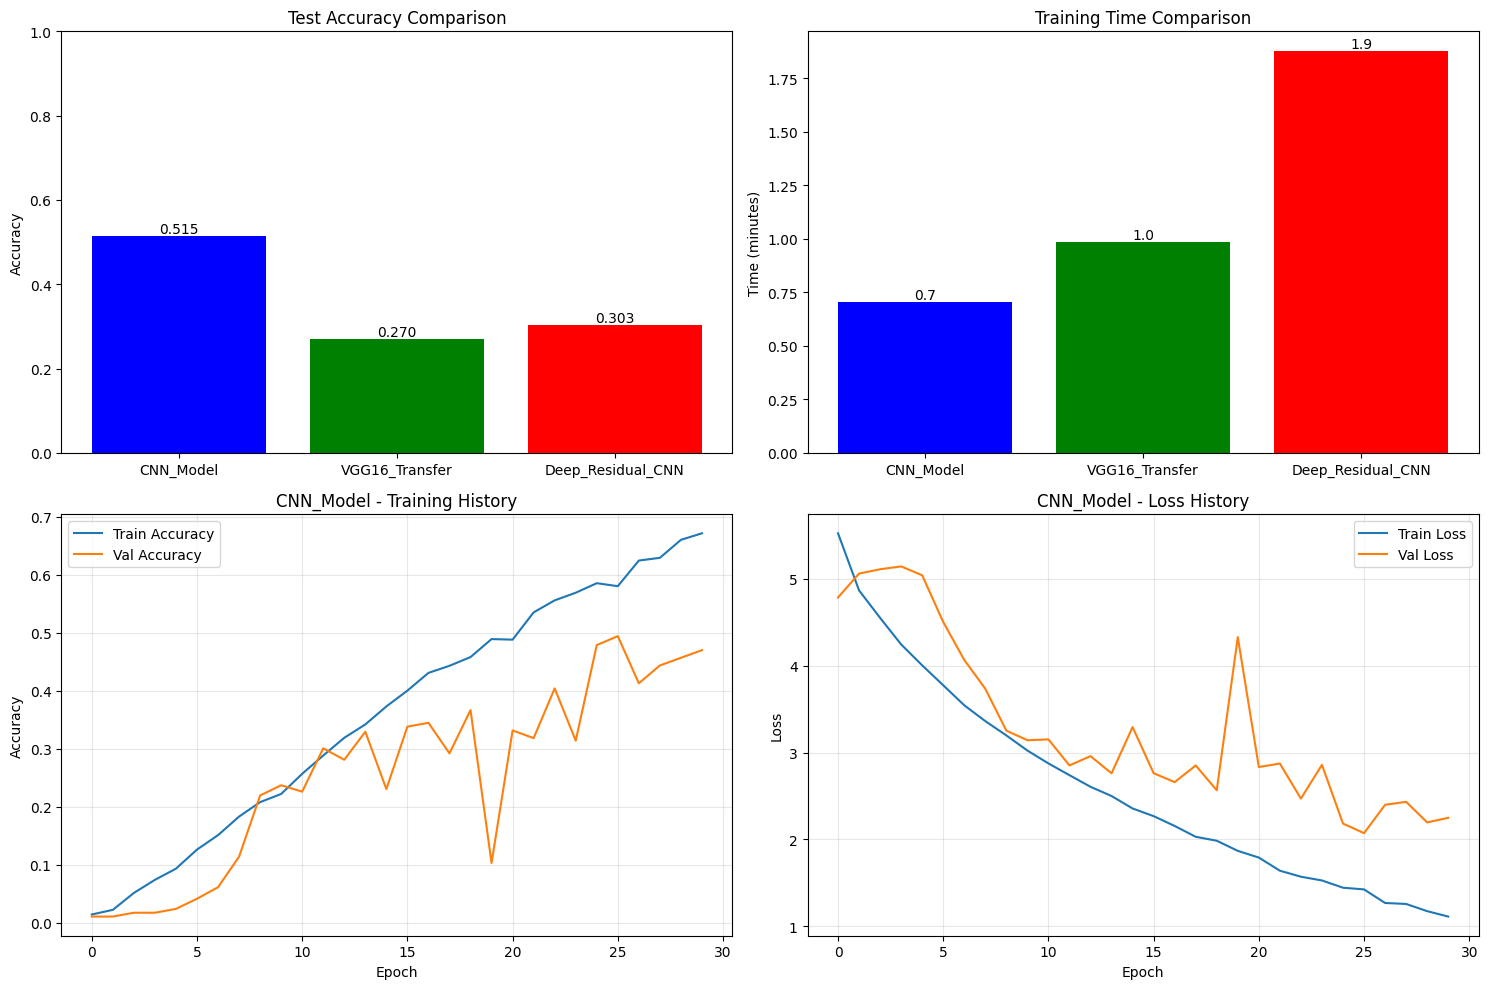

In [19]:

# ============================================
# CELL 5: VISUALIZATION
# ============================================
print("\nVISUALIZING RESULTS")
print("=" * 50)


fig, axes = plt.subplots(2, 2, figsize=(15, 10))


ax1 = axes[0, 0]
models = list(MODEL_RESULTS.keys())
test_accs = [MODEL_RESULTS[m]['test_accuracy'] for m in models]
bars = ax1.bar(models, test_accs, color=['blue', 'green', 'red'])
ax1.set_title('Test Accuracy Comparison')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0, 1])
for bar, acc in zip(bars, test_accs):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.3f}', ha='center', va='bottom')


ax2 = axes[0, 1]
train_times = [MODEL_RESULTS[m]['training_time']/60 for m in models]
bars = ax2.bar(models, train_times, color=['blue', 'green', 'red'])
ax2.set_title('Training Time Comparison')
ax2.set_ylabel('Time (minutes)')
for bar, time in zip(bars, train_times):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{time:.1f}', ha='center', va='bottom')


ax3 = axes[1, 0]
best_history = MODEL_RESULTS[best_model_name]['history']
ax3.plot(best_history.history['accuracy'], label='Train Accuracy')
ax3.plot(best_history.history['val_accuracy'], label='Val Accuracy')
ax3.set_title(f'{best_model_name} - Training History')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Best Model Training History - Loss
ax4 = axes[1, 1]
ax4.plot(best_history.history['loss'], label='Train Loss')
ax4.plot(best_history.history['val_loss'], label='Val Loss')
ax4.set_title(f'{best_model_name} - Loss History')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Single Image Prediction

STEP 8: SINGLE IMAGE PREDICTION FUNCTION
Loaded mapping for 100 classes
Sample mapping: Class 0 -> Celebrity ID 2820

Testing single image celebrity prediction...


2025-09-29 21:27:55.004944: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.19 = (f32[1,32,60,60]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,32,62,62]{3,2,1,0} %bitcast.535, f32[32,32,3,3]{3,2,1,0} %bitcast.542, f32[32]{0} %bitcast.544), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1_2/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-29 21:27:55.030299: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algo


Correct Prediction - Test Image 1
Image: 000001.jpg
Ground Truth - Celebrity ID: 2880 | Class: 23


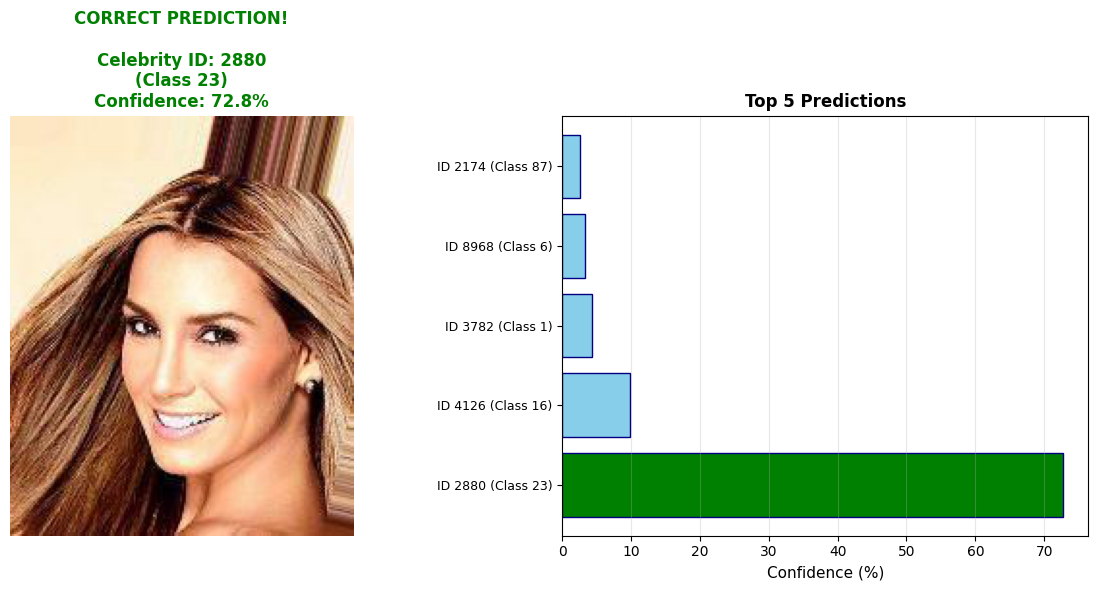


Prediction for: 000001.jpg
Celebrity ID: 2880
PREDICTION: CORRECT!
> 1. Celebrity ID:  2880 | Class:  23 | Confidence:  72.79%
  2. Celebrity ID:  4126 | Class:  16 | Confidence:   9.81%
  3. Celebrity ID:  3782 | Class:   1 | Confidence:   4.32%
  4. Celebrity ID:  8968 | Class:   6 | Confidence:   3.29%
  5. Celebrity ID:  2174 | Class:  87 | Confidence:   2.62%

Correct Prediction - Test Image 2
Image: 004183.jpg
Ground Truth - Celebrity ID: 4308 | Class: 62


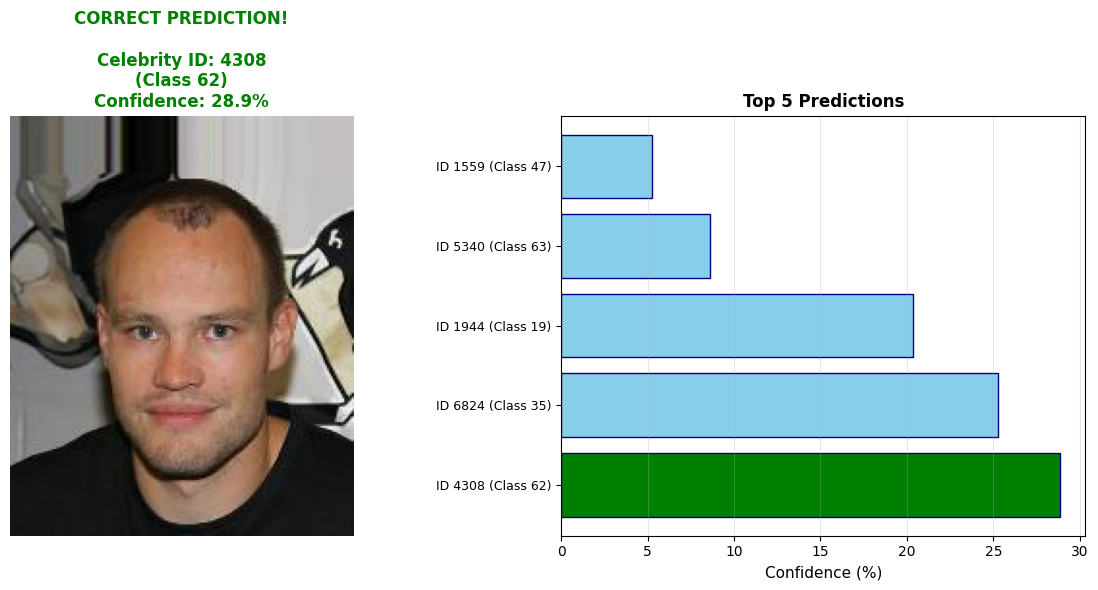


Prediction for: 004183.jpg
Celebrity ID: 4308
PREDICTION: CORRECT!
> 1. Celebrity ID:  4308 | Class:  62 | Confidence:  28.88%
  2. Celebrity ID:  6824 | Class:  35 | Confidence:  25.27%
  3. Celebrity ID:  1944 | Class:  19 | Confidence:  20.38%
  4. Celebrity ID:  5340 | Class:  63 | Confidence:   8.59%
  5. Celebrity ID:  1559 | Class:  47 | Confidence:   5.26%

Correct Prediction - Test Image 3
Image: 006656.jpg
Ground Truth - Celebrity ID: 1559 | Class: 47


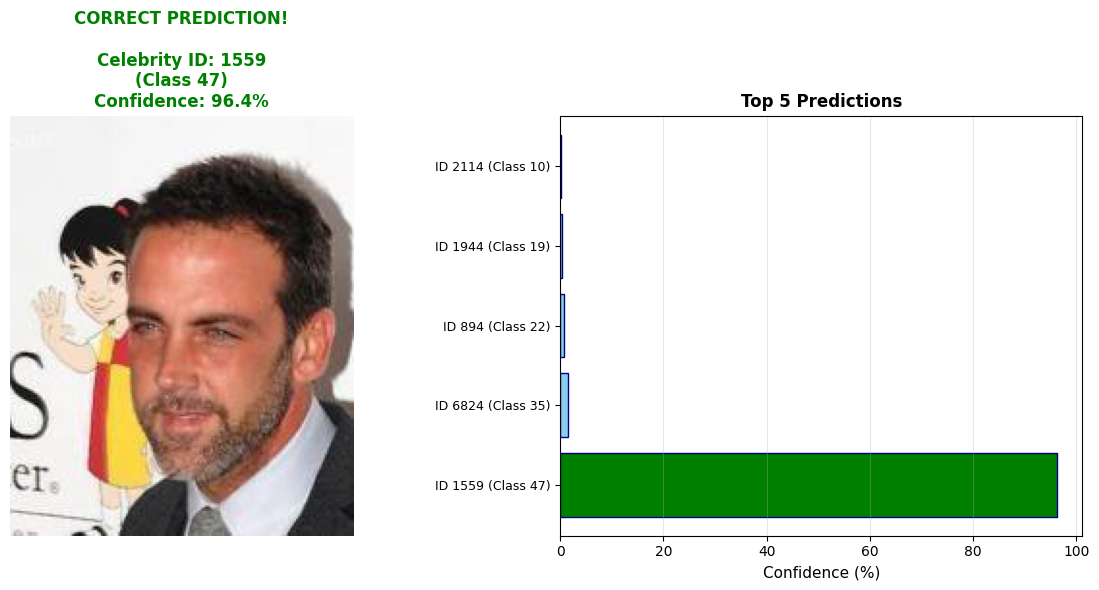


Prediction for: 006656.jpg
Celebrity ID: 1559
PREDICTION: CORRECT!
> 1. Celebrity ID:  1559 | Class:  47 | Confidence:  96.38%
  2. Celebrity ID:  6824 | Class:  35 | Confidence:   1.49%
  3. Celebrity ID:   894 | Class:  22 | Confidence:   0.74%
  4. Celebrity ID:  1944 | Class:  19 | Confidence:   0.28%
  5. Celebrity ID:  2114 | Class:  10 | Confidence:   0.23%

PREDICTION SUMMARY
Total Predictions Tested: 3
Correct Predictions Shown: 3
Accuracy: 100.0%


In [20]:

print("STEP 8: SINGLE IMAGE PREDICTION FUNCTION")
print("=" * 50)

label_to_celeb_id = df_subset.groupby('celebrity_label')['celebrity_id'].first().to_dict()

print(f"Loaded mapping for {len(label_to_celeb_id)} classes")
print(f"Sample mapping: Class 0 -> Celebrity ID {label_to_celeb_id[0]}")

def predict_celebrity_image(image_path, model, top_k=5):
    
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize(IMG_SIZE)
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        predictions = model.predict(img_array, verbose=0)[0]
        
        top_indices = np.argsort(predictions)[-top_k:][::-1]
        
        results = {
            'image_path': image_path,
            'top_predictions': []
        }
        
        for i, idx in enumerate(top_indices):
            confidence = predictions[idx] * 100
            celebrity_id = label_to_celeb_id.get(int(idx), -1)
            results['top_predictions'].append({
                'rank': i + 1,
                'celebrity_class': int(idx),
                'celebrity_id': celebrity_id,
                'confidence': confidence
            })
        
        return results
        
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

def display_prediction_with_image(image_path, results, actual_celeb_id):
    
    if results is None:
        return
    
    predicted_celeb_id = results['top_predictions'][0]['celebrity_id']
    is_correct = (predicted_celeb_id == actual_celeb_id)
    
    if not is_correct:
        return
    
    plt.figure(figsize=(12, 6))
    
    img = Image.open(image_path)
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    top_pred = results['top_predictions'][0]
    
    title = f'CORRECT PREDICTION!\n\nCelebrity ID: {top_pred["celebrity_id"]}\n(Class {top_pred["celebrity_class"]})\nConfidence: {top_pred["confidence"]:.1f}%'
    plt.title(title, fontsize=12, fontweight='bold', color='green')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    labels = [f'ID {p["celebrity_id"]} (Class {p["celebrity_class"]})' for p in results['top_predictions']]
    confidences = [p['confidence'] for p in results['top_predictions']]
    
    colors = ['green' if p['celebrity_id'] == actual_celeb_id else 'skyblue' for p in results['top_predictions']]
    
    plt.barh(range(len(labels)), confidences, color=colors, edgecolor='navy')
    plt.yticks(range(len(labels)), labels, fontsize=9)
    plt.xlabel('Confidence (%)', fontsize=11)
    plt.title('Top 5 Predictions', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nPrediction for: {os.path.basename(image_path)}")
    print("=" * 80)
    print(f"Celebrity ID: {actual_celeb_id}")
    print("PREDICTION: CORRECT!")
    print("=" * 80)
    
    for pred in results['top_predictions']:
        marker = ">" if pred['celebrity_id'] == actual_celeb_id else " "
        print(f"{marker} {pred['rank']}. Celebrity ID: {pred['celebrity_id']:5d} | "
              f"Class: {pred['celebrity_class']:3d} | "
              f"Confidence: {pred['confidence']:6.2f}%")
    print("=" * 80)

model = best_model

print("\nTesting single image celebrity prediction...")
sample_indices = [0, 50, 100]

correct_predictions = 0
total_predictions = 0

for i, idx in enumerate(sample_indices):
    if idx < len(df_subset):
        sample_image_path = os.path.join(IMG_DIR, df_subset.iloc[idx]['image_filename'])
        actual_celeb_id = df_subset.iloc[idx]['celebrity_id']
        actual_class = df_subset.iloc[idx]['celebrity_label']
        
        if os.path.exists(sample_image_path):
            results = predict_celebrity_image(sample_image_path, model)
            if results:
                predicted_celeb_id = results['top_predictions'][0]['celebrity_id']
                
                if predicted_celeb_id == actual_celeb_id:
                    print(f"\n{'='*80}")
                    print(f"Correct Prediction - Test Image {i+1}")
                    print(f"Image: {df_subset.iloc[idx]['image_filename']}")
                    print(f"Ground Truth - Celebrity ID: {actual_celeb_id} | Class: {actual_class}")
                    print('='*80)
                    
                    display_prediction_with_image(sample_image_path, results, actual_celeb_id)
                    correct_predictions += 1
                
                total_predictions += 1

print(f"\n{'='*80}")
print(f"PREDICTION SUMMARY")
print(f"{'='*80}")
print(f"Total Predictions Tested: {total_predictions}")
print(f"Correct Predictions Shown: {correct_predictions}")
if total_predictions > 0:
    accuracy = (correct_predictions/total_predictions)*100
    print(f"Accuracy: {accuracy:.1f}%")
print(f"{'='*80}")


